## Evalute the magic of real-valued quantum states

Magic states are the resource that allows quantum computers to attain an advantage over classical computers. This resource consists in the deviation from a property called stabilizerness which in turn implies that stabilizer circuits can be efficiently simulated on a classical computer. 

In this notebook, we demonstarte how to meausre the magic of real-valued quantum states through $\alpha$-Rényi Stabilizer Entropy (RSE) [1]
$$
M_\alpha(|\psi\rangle)= \frac{1}{1-\alpha} \log_2 \left(\sum_{\sigma \in \mathcal{P}} 2^{-n}\langle\psi| \sigma|\psi\rangle^{2 \alpha}\right), \tag{1}
$$
where $\alpha$ is the entropic index and $\mathcal{P}$ is the set of $4^n$ Pauli strings.


### Benchmark the magic meausre

It is know that $M_\alpha(|\psi_{\text{STAB}}\rangle)=0$ for pure stabilizer states $|\psi_{\text{STAB}}\rangle$. The Clifford group is generated by $\mathcal{S}_{\text{Clifford}} \in \{ H,S,CNOT\}$. We can use the Clifford group to generate a random stabilizer state adn verify the calculation of $M_\alpha(\cdot)$. This code implementation is based on [1] and their [GitHub repo](https://github.com/txhaug/stabilizer_entropy).

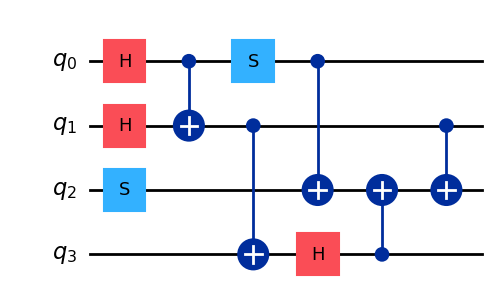

In [2]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import StabilizerState, Pauli, Statevector
import hadamard_random_forest as hrf

# Generate a stabilizer state
qc = QuantumCircuit(4)
qc.h(0)
qc.h(1)
qc.s(2)
qc.cx(0, 1)
qc.cx(1, 3)
qc.s(0)
qc.h(3)
qc.cx(0, 2)
qc.cx(3, 2)
qc.cx(1, 2)

qc.draw("mpl", fold=-1)

In [3]:
# Generate the statevector
psi = Statevector(qc)

# Calculate Stabilizer Entropy
alpha = 2
SE = hrf.stabilizer_entropy(alpha, psi)
print("Stabilizer Renyi entropy (exact) =", SE)

Stabilizer Renyi entropy (exact) = 2.5627412030519365e-15


Notice the stabilizer entropy will suddenly be nonzero if we add a single $T$-gate at the end of above circuit.

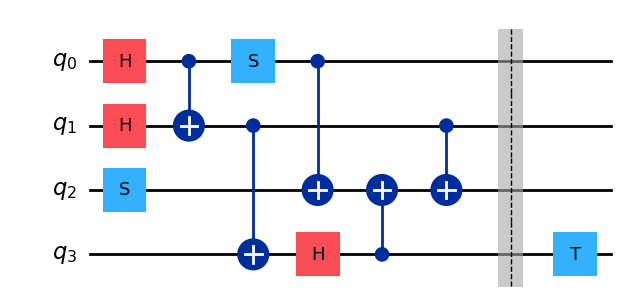

In [4]:
# Generate a non-stabilizer state
qc = QuantumCircuit(4)
qc.h(0)
qc.h(1)
qc.s(2)
qc.cx(0, 1)
qc.cx(1, 3)
qc.s(0)
qc.h(3)
qc.cx(0, 2)
qc.cx(3, 2)
qc.cx(1, 2)

# ==== Add a T-gate ====
qc.barrier()
qc.t(3)
# ======================

qc.draw("mpl", fold=-1)

In [5]:
# Generate the statevector
psi = Statevector(qc)

# Calculate Stabilizer Entropy
alpha = 2
SE = hrf.stabilizer_entropy(alpha, psi)
print("Stabilizer Renyi entropy (exact) =", SE)

Stabilizer Renyi entropy (exact) = 0.41503749927884726


It can also be derived easily as $M_2(\sqrt{T}|+\rangle) = 3-\log_2 7 \approx 0.192645$, where $\sqrt{T}$ gate induces an $\pi/8$ radian rotation about the $Z$-axis [2].

In [6]:
# Generate a magic state
qc = QuantumCircuit(1)
qc.h(0)
qc.rz(np.pi/8, 0)

# Generate the statevector
psi = Statevector(qc)

# Calculate Stabilizer Entropy
alpha = 2
SE = hrf.stabilizer_entropy(alpha, psi)
print("Stabilizer Renyi entropy (exact) =", SE)
print("Stabilizer Renyi entropy (expected) =", 3-np.log2(7))

Stabilizer Renyi entropy (exact) = 0.19264507794239719
Stabilizer Renyi entropy (expected) = 0.19264507794239583


### Random real-valued states generated by $\mathcal{S}_{\text{gate}} \in\{R_y(\theta), CNOT\}$

We can use the `RealAmplitudes` ansatz from Qiskit to prepare such real-valued quantum states.

In [ ]:
import random
from tqdm.auto import tqdm
from qiskit.circuit.library import RealAmplitudes

# Set up circuit width 
min_qubit = 2
max_qubit = 8
qubit_list = [n for n in range(min_qubit, max_qubit+1, 2)]

# Set up circuit length
min_layer = 1
max_layer = 20
scan_layer = 1
layer_list = [l for l in range(min_layer, max_layer+1, scan_layer)]

# Record the Stabilizer Entropy 
SE_list = np.zeros((len(qubit_list), len(layer_list)))

# Set up the random seeds to generate parameter for Ry(theta)
random.seed(99)

for inum_qubits in tqdm(qubit_list, desc="Qubits"):
    for num_layers in tqdm(layer_list, desc="Layers", leave=False):

        seed = random.randint(0, 100000)
        rng = np.random.default_rng(seed)
        
        # Prepare a parametrized real-valued quantum state
        ansatz = RealAmplitudes(num_qubits, entanglement='pairwise', reps=num_layers, skip_final_rotation_layer=True)
        params = rng.uniform(-np.pi, np.pi, ansatz.num_parameters)

        # Bind parameters
        ansatz.assign_parameters(params, inplace=True)
        
        # Get statevector
        psi = Statevector(ansatz)
    
        # Calculate Stabilizer Entropy
        alpha = 2
        SE = hrf.stabilizer_entropy(alpha, psi)
        SE_list[int(num_qubits/2)-1, int(num_layers/scan_layer)-1] = SE

Qubits:   0%|          | 0/4 [00:00<?, ?it/s]

Layers:   0%|          | 0/20 [00:00<?, ?it/s]

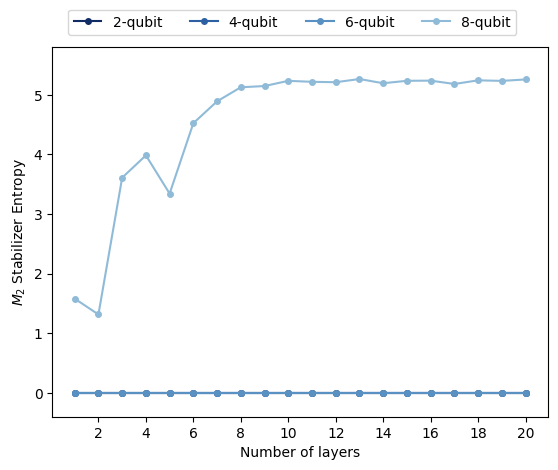

In [18]:
import matplotlib.pyplot as plt

blue_string1 = '#112C65'
blue_string2 = '#2D5FA3'
blue_string3 = '#5991C2'
blue_string4 = '#90BBD8'
blue_string5 = '#C9D9ED'

plt.plot(layer_list, SE_list[0,:], 'o-', markersize=4, alpha=1, color=blue_string1, label="2-qubit", markerfacecolor=blue_string1, markeredgecolor=blue_string1)
plt.plot(layer_list, SE_list[1,:], 'o-', markersize=4, alpha=1, color=blue_string2, label="4-qubit", markerfacecolor=blue_string2, markeredgecolor=blue_string2)
plt.plot(layer_list, SE_list[2,:], 'o-', markersize=4, alpha=1, color=blue_string3, label="6-qubit", markerfacecolor=blue_string3, markeredgecolor=blue_string3)
plt.plot(layer_list, SE_list[3,:], 'o-', markersize=4, alpha=1, color=blue_string4, label="8-qubit", markerfacecolor=blue_string4, markeredgecolor=blue_string4)

plt.ylim([-0.4, 5.8])
plt.xlabel(r"Number of layers")
plt.ylabel(r"$M_2$ Stabilizer Entropy")
plt.xticks([i for i in range(2,21,2)])
plt.legend(bbox_to_anchor=(0.95, 1.12), ncol=4)

## Reference

[1] [Haug, Tobias, Soovin Lee, and M. S. Kim. "Efficient quantum algorithms for stabilizer entropies." Physical Review Letters 132.24 (2024): 240602.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.132.240602) \
[2] [Zhu, Chengkai, et al. "Amortized Stabilizer R\'enyi Entropy of Quantum Dynamics." arXiv preprint arXiv:2409.06659 (2024).](https://arxiv.org/abs/2409.06659) 

---
## Software info

In [7]:
import qiskit

print(f'Qiskit: {qiskit.__version__}')

Qiskit: 2.0.0
